
# 📊 Value at Risk (VaR) & Expected Shortfall (ES) Analysis

---

This notebook explores **three different approaches** to calculating **Value at Risk (VaR)** and **Expected Shortfall (ES)**.  
Both concepts are **crucial in risk analysis and portfolio management**.

---

## 🔍 What are VaR and ES?

- **Value at Risk (VaR):**  
  The maximum single-day loss a portfolio is expected to face at a given confidence level.  
  > Example: If the 95% VaR = \$10,000, we can be 95% confident the portfolio will **not lose more than \$10,000 in a single day**.

- **Expected Shortfall (ES):**  
  The **average loss** given that losses exceed the VaR threshold. In other words, ES captures the *tail risk* beyond VaR.

---

## 🧮 Methods Explored

1. **Empirical Approach** – Uses historical data directly to estimate quantiles.  
2. **Normal Estimation Approach** – Assumes returns are normally distributed and calculates VaR/ES analytically.  
3. **Monte Carlo Simulation Approach** – Generates simulated returns based on statistical properties of the portfolio.

---

## 📅 Time Horizons

While VaR and ES are often calculated on a **daily basis**, they can be expanded to forecast potential losses over longer timeframes.  
> ⚠️ This notebook focuses only on the **single-day perspective**, as multi-day VaR/ES is less common in practice.

---

## 💡 Why This Matters

These tools give portfolio managers a **quantitative overview of downside risk** and support decision-making around:

- Position sizing  
- Portfolio hedging  
- Regulatory compliance  

---

## 🤝 Contribute

If you have suggestions or would like to contribute to this code, you can find all my information on my **[GitHub](https://github.com/WernkeJD)**.



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


#var and es variable defs
notional = 1000000
alpha = 0.95

In [2]:
#helpers

def generate_tickers(portfolio_allocation: dict):
    tickers = []

    for item in portfolio_allocation.keys():
        tickers.append(item.upper())

    return tickers

def generate_starting_portfolio(notional: int, prices: pd.DataFrame, portfolio_allocation: dict) -> pd.DataFrame:

  shares = pd.Series(index=portfolio_allocation.index)

  for ticker in prices.columns:
    shares[ticker] = notional * portfolio_allocation[ticker] / prices[ticker].iloc[0]

  return shares

def generate_portfolio_pnl(notional: int, returns: pd.Series) -> pd.Series:
    return notional * np.exp(returns.cumsum())

def generate_one_day_losses(notional: int, returns: pd.Series, var: float) -> np.array:
  breaches = returns <= -var
  usd_losses = notional * (1-np.exp(returns[breaches]))
  return usd_losses




# VaR and ES Calculation

Below demonstrates the steps neccessary to calculat VaR, value at risk, and ES, expected shortfall. Combined these two metrics give a solid idea of the potential losses a portfolio may encounter with a given level of confidence. VaR provides the most likely worst return for a given portfolio with a provided confidence level, in the case below 95%. ES provides the most likely return given that we encounter a scenario worse than the predicted VaR level.

### step 1
this step simply defines our portfolio as a dictionary. although the line "allocation_series /= allocation_series.sum()" in step three would allow us to set weights randomly, the purpose of this segment of the project has no need for this so weights are hard coded and still equal 1.

### step 2
In this step we use the tickers from the weights array combined with the yfinance library to download the closing prices for the stocks going back 2 years. Additionally we calculate log returns, defined as ln(Pt/Pt-1). Log returns are additive over time and better suited for risk models that assume normality. For small changes, log returns approximate simple percentage changes.


### step 3
Here we take the weights and turn them into a pd.Series for easier matrix multiplication. Portfolio returns are computed as the weighted sum of individual asset returns, where weights are normalized to sum to 1. This effectively simulates daily rebalancing of the portfolio.

### step 4
we calculate VaR and ES for a given alpha using the pandas quantile method on our calculated returns array. We scale the return-based VaR and ES by the notional portfolio value to translate them into dollar terms.



In [5]:


#Step 1 - Define portfolio allocation

# portfolio_weights = {
#     "SPY": 0.25, "IWM": 0.10, "EFA": 0.05, #Equities 40%
#     "TLT": 0.15, "IEF": 0.05, #rates 20%
#     "VBTIX": 0.10, "ABNFX": 0.10, #Bonds 20%
#     "FXE":0.25,"FXY":0.20 #Fx

# }

portfolio_weights = {
    "TSLA": 1.00
}

#Step 2 - Generate Data

tickers = generate_tickers(portfolio_weights)
price_data = yf.download(tickers, period='720d')['Close']
print("\n")
returns = np.log(price_data / price_data.shift(1)).dropna()

#Step 3 - turn weights to pandas series and use matrix multiplication to calculate weighted portfolio returns

allocation_series = pd.Series(portfolio_weights)
allocation_series /= allocation_series.sum()
portfolio_returns = returns[list(allocation_series.index)] @ allocation_series.values

#Step 4 - Calculate VaR and ES

q = portfolio_returns.quantile(1-alpha)
VaR = -q
ES = -portfolio_returns[portfolio_returns <= q].mean()
print("var % ", VaR)
print("ES %", ES)
print("var $ ", notional * (1-np.exp(q)))
print("ES $", notional * -(1-np.exp(ES)))


/tmp/ipython-input-2956472462.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, period='720d')['Close']
[*********************100%***********************]  1 of 1 completed



var %  0.0586861956180619
ES % 0.08737561508685777
var $  56997.35890732904
ES $ 91306.51393452194


# VaR, ES, and Portfolio Graphs and Stats

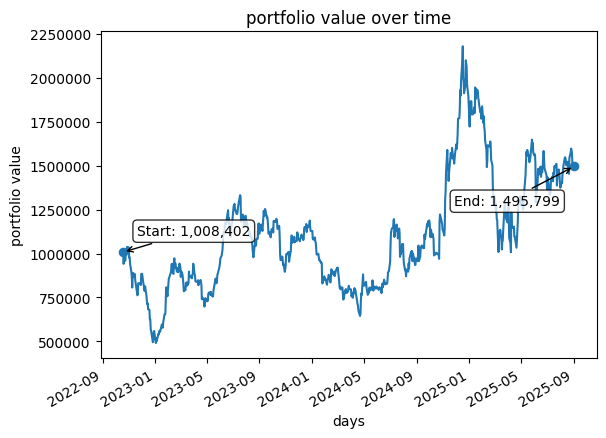

36
719


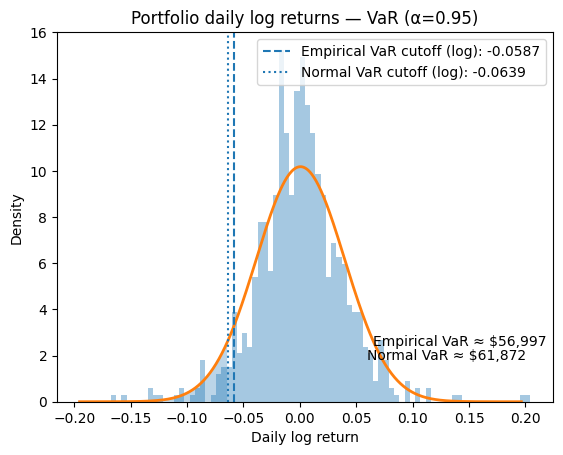

In [6]:
#potfolio value calculation

pnl = generate_portfolio_pnl(notional, portfolio_returns)
pnl.plot()
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
# Highlight & label start/end points
start_x, start_y = pnl.index[0], pnl.iloc[0]
end_x, end_y     = pnl.index[-1], pnl.iloc[-1]

# draw small markers so the arrows have a target
ax.scatter([start_x, end_x], [start_y, end_y], s=35, zorder=3)

ax.annotate(
    f"Start: {start_y:,.0f}",
    xy=(start_x, start_y),
    xytext=(10, 10), textcoords="offset points",
    ha="left", va="bottom",
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
)

ax.annotate(
    f"End: {end_y:,.0f}",
    xy=(end_x, end_y),
    xytext=(-10, -20), textcoords="offset points",
    ha="right", va="top",
    arrowprops=dict(arrowstyle="->", lw=1),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
)
plt.xlabel('days')
plt.ylabel('portfolio value')
plt.title('portfolio value over time')
plt.show()
losses = generate_one_day_losses(notional, portfolio_returns, VaR)
print(len(losses))
print(len(pnl))


#VaR and ES graphed

#Update Data for normal dist graphing
mu, sigma = portfolio_returns.mean(), portfolio_returns.std(ddof=1)

q_norm = norm.ppf(1-alpha, loc=mu, scale=sigma)


VaR_emp_usd = notional * (1-np.exp(q))
VaR_norm_usd = notional * (1-np.exp(q_norm))

# 3) Plot histogram + normal PDF
fig, ax = plt.subplots()
ax.hist(portfolio_returns, bins=80, density=True, alpha=0.4)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 600)
ax.plot(x, norm.pdf(x, mu, sigma), lw=2)

# Shade the left tail under the normal fit up to the normal VaR cutoff
mask = x <= q_norm
ax.fill_between(x[mask], norm.pdf(x, mu, sigma)[mask], alpha=0.3)

# 4) Draw VaR lines and annotate in both log and $
ax.axvline(q,  ls='--', lw=1.5, label=f'Empirical VaR cutoff (log): {q:.4f}')
ax.axvline(q_norm, ls=':',  lw=1.5, label=f'Normal VaR cutoff (log): {q_norm:.4f}')

ax.annotate(f"Empirical VaR ≈ ${VaR_emp_usd:,.0f}",
            xy=(q, 0), xytext=(100, 40), textcoords='offset points')
ax.annotate(f"Normal VaR ≈ ${VaR_norm_usd:,.0f}",
            xy=(q_norm, 0), xytext=(100, 30), textcoords='offset points')

ax.set_title(f"Portfolio daily log returns — VaR (α={alpha:.2f})")
ax.set_xlabel("Daily log return")
ax.set_ylabel("Density")
ax.legend()
plt.show()


# Monte Carlo Simulation

Monte Carlo Simulation for Risk Estimation

Monte Carlo simulation provides an alternative way to estimate portfolio risk by simulating many possible future return paths based on historical mean and covariance structures.

###**Step 1 — Estimate Distribution Parameters**
We use historical data to calculate the mean daily returns and covariance matrix of the assets in our portfolio. These form the foundation of our simulation, ensuring the generated scenarios are consistent with observed asset behavior.

###**Step 2 — Generate Random Shocks**
We create thousands of random draws from a standard normal distribution. By applying the Cholesky decomposition of the covariance matrix, we introduce realistic correlations between assets.

###**Step 3 — Simulate Portfolio Paths**
Using the random shocks and mean returns, we simulate daily asset returns over the chosen time horizon. These are aggregated into portfolio-level returns using the portfolio weights. Repeating this many times (e.g., 10,000 simulations) produces a distribution of potential portfolio values.

###**Step 4 — Calculate Monte Carlo VaR and ES**
From the simulated distribution of final-day returns, we calculate VaR as the loss threshold not exceeded with probability α (e.g., 95%). ES is then the expected loss conditional on losses beyond this threshold. These metrics provide a probabilistic forecast of downside risk based on simulated future states, rather than solely historical observations.

###**Step 5 — Visualization**
Simulated portfolio paths can be plotted to visually demonstrate the range of possible future outcomes, highlighting both the central tendency and extreme downside scenarios.

In [ ]:
#helpers

def mc_data_generation(stocks: list, start: dt.datetime , end: dt.datetime):
  stock_data = yf.download(stocks, start, end)['Close']
  returns = stock_data.pct_change()
  mean_returns = returns.mean()
  cov_matrix = returns.cov()

  return mean_returns, cov_matrix

def monte_carlo_sim(num_sims: int, timeframe: int, stocks: list, mean_returns: pd.Series, cov_matrix: pd.Series, weights: dict, notional: int):

  portfolio_sims = np.full(shape=(timeframe, num_sims), fill_value=0.0)

  mean_matrix = np.full(shape=(timeframe, len(stocks)), fill_value=(mean_returns))
  mean_matrix = mean_matrix.T

  for item in range(0, num_sims):
    z_score = np.random.normal(size=(timeframe, len(stocks)))
    l_tri = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_matrix + np.inner(l_tri, z_score)
    portfolio_sims[:, item] = np.cumprod(np.inner(weights, daily_returns.T) + 1)*notional

  return portfolio_sims

def calculate_returns(mc_sims: np.array):
  last = mc_sims[-1, :]
  prev = mc_sims[-2, :]
  returns = (last - prev) / prev
  returns = pd.Series(returns)
  return returns

def calculate_mc_var(returns: pd.Series):
  return -returns.quantile(1-alpha)

def calculate_mc_es(returns: pd.Series):
  return -returns[returns < -calculate_mc_var(returns)].mean()

/tmp/ipython-input-3642125370.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stocks, start, end)['Close']
[*********************100%***********************]  9 of 9 completed
/tmp/ipython-input-3642125370.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = stock_data.pct_change()


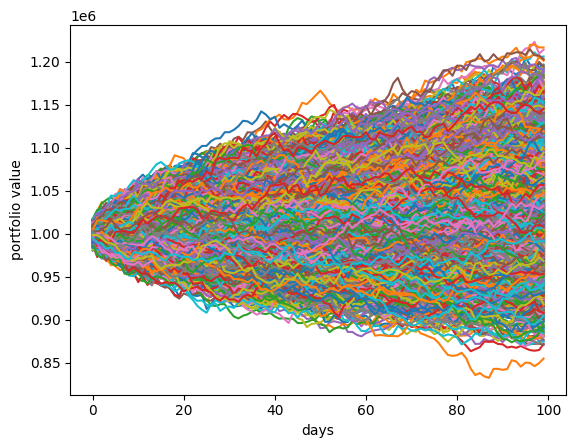

In [ ]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=720)
mean_returns, cov_matrix = mc_data_generation(tickers, start_date, end_date)


portfolio_sims = monte_carlo_sim(10000, 100, tickers, mean_returns, cov_matrix, allocation_series, notional)
plt.plot(portfolio_sims)
plt.ylabel('portfolio value')
plt.xlabel('days')
plt.show()

In [ ]:
portfolio_results = pd.Series(portfolio_sims[-1, :])
portfolio_returns = calculate_returns(portfolio_sims)

mcvar = calculate_mc_var(portfolio_returns)
mcES = calculate_mc_es(portfolio_returns)
print("mc var %: ", mcvar)
print("mc es %: ", mcES)
print("mc var $: ", mcvar * notional)
print("mc es $: ", mcES * notional )

mc var %:  0.007730993735445659
mc es %:  0.009790806742534325
mc var $:  7730.993735445659
mc es $:  9790.806742534325


## 📌 Conclusion

Each VaR calculation method applied to our market portfolio produces broadly similar results, but there are key differences worth noting.  

- The **empirical method** directly relies on historical data, making it the most faithful to observed returns. In our case, the portfolio’s returns are already close to normally distributed, so this approach aligns well with the normal estimation. However, in portfolios with less diversification, returns often exhibit **fatter tails**, which the normal approximation would fail to capture.  

- The **normal estimation method** is simple and computationally efficient, but its assumption of normality can underestimate tail risk when distributions deviate significantly from Gaussian behavior.  

- The **Monte Carlo method**, on the other hand, is **forward-looking**. By generating simulated return paths, it allows us to incorporate assumptions about volatility, correlations, and potential market shocks. This makes it a powerful tool for stress testing and scenario analysis, though it is more computationally intensive.  

In practice, portfolio managers often use these methods together: empirical VaR for historical grounding, normal VaR for speed and simplicity, and Monte Carlo for flexibility and forward-looking insights. Taken together, they provide a more holistic picture of portfolio risk and its potential vulnerabilities.

---

## 📊 Method Comparison

| Method                | Strengths ✅                                                                 | Weaknesses ⚠️                                                                 |
|-----------------------|------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Empirical**         | Uses actual historical data; no distributional assumptions.                  | Limited by past data; may not capture future shocks.                          |
| **Normal Estimation** | Fast and easy to compute; intuitive analytical formulas.                     | Assumes normality → underestimates tail risk if returns have fat tails.       |
| **Monte Carlo**       | Flexible; forward-looking; allows scenario and stress testing.   

# Resources


*   https://www.youtube.com/watch?v=6-dhdMDiYWQ
*   https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662

*   https://www.forrs.de/en/news/var-vs-es



